# Подбор модели и гипперпараметров к ней

In [12]:
from python_files.data import data
data_ = data.copy()
from python_files.strength.str_col_list import str_x_col_list, str_col_list_norm, str_col_list_std
from python_files.strength.str_outliers import X_train, X_test, y_train, y_test

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [14]:
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler

## 1. Предобработка данных

Выполним нормализацию и стандартизацию данных перед подачей на модели. Выбросы в данных обрабатывать не будем. В препроцессоре будем нормализовывать и стандартизировать признаки с исходным распределением близким к нормальному и только стандартизировать признаки в которых исходное распределение отличается от нормального, т.е. попробуем сохранить исходные закономерности распределения величин в признаках.

In [15]:
# создадим препроцессор, который нормализует и стандартизирует данные
str_preprocessor = ColumnTransformer(
    transformers=[
        ('normalization', PowerTransformer(), str_col_list_norm), 
        ('scaling', StandardScaler(), str_col_list_std) 
    ])

In [16]:
# нормализуем и стандартизируем
X_train_proc_str = str_preprocessor.fit_transform(X_train)
X_train_proc_str = pd.DataFrame(data = X_train_proc_str, columns = str_x_col_list)

In [17]:
# посмотрим что получили
X_train_proc_str.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02,7.160000e+02
mean,4.614558e-16,-9.849353e-16,1.538186e-16,-9.923781e-17,3.771037e-16,6.400839e-16,1.488071e-14,2.505755e-16,-1.538186e-16,1.339710e-16,2.480945e-17,1.736662e-17
std,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00,1.000699e+00
min,-2.795399e+00,-3.315188e+00,-2.499446e+00,-3.107488e+00,-3.336638e+00,-4.033827e+00,-3.142326e+00,-2.919919e+00,-2.872446e+00,-3.521669e+00,-1.694802e+00,-9.509234e-01
25%,-6.774696e-01,-6.819911e-01,-7.012970e-01,-6.498695e-01,-6.554573e-01,-6.708632e-01,-6.833687e-01,-6.544999e-01,-7.138652e-01,-6.247278e-01,-7.538111e-01,-9.509234e-01
50%,-5.449606e-03,6.003169e-02,6.271705e-02,-1.396741e-02,2.268079e-02,-1.127425e-02,1.319726e-02,2.973862e-02,1.974265e-02,-2.830320e-02,-1.229207e-01,-9.509234e-01
75%,6.969612e-01,6.328932e-01,7.033977e-01,6.570965e-01,7.072717e-01,6.544604e-01,6.778916e-01,6.671943e-01,6.777051e-01,6.337152e-01,7.364751e-01,1.051609e+00
max,2.472931e+00,3.054018e+00,3.220805e+00,3.219462e+00,4.283174e+00,2.965476e+00,2.755187e+00,3.119044e+00,2.943353e+00,4.246995e+00,3.188903e+00,1.051609e+00


In [18]:
# нормализуем и стандартизируем
X_test_proc_str = str_preprocessor.fit_transform(X_test)
X_test_proc_str = pd.DataFrame(data = X_test_proc_str, columns = str_x_col_list)

In [19]:
# посмотрим что получили
X_test_proc_str.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02,3.070000e+02
mean,-1.186167e-16,-1.735854e-16,-3.876740e-16,8.823922e-17,-1.197739e-15,1.955728e-15,6.243287e-15,1.822646e-16,3.529569e-16,8.505683e-16,1.562268e-16,-2.314471e-17
std,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00,1.001633e+00
min,-3.083922e+00,-3.339712e+00,-2.610324e+00,-2.376389e+00,-2.578746e+00,-2.718387e+00,-2.691937e+00,-2.844819e+00,-2.819744e+00,-2.821342e+00,-1.754746e+00,-1.063929e+00
25%,-6.424146e-01,-7.127235e-01,-6.312770e-01,-6.581292e-01,-7.303454e-01,-6.517812e-01,-6.056293e-01,-6.438238e-01,-6.503528e-01,-5.809343e-01,-8.137726e-01,-1.063929e+00
50%,-4.588991e-03,-2.221703e-02,3.477098e-02,-1.796052e-02,-1.377916e-02,-1.066009e-02,-5.161639e-02,-3.731267e-02,2.665018e-03,5.439046e-03,-8.533846e-02,9.399125e-01
75%,6.508900e-01,6.317405e-01,6.770494e-01,6.951754e-01,7.548550e-01,6.689175e-01,6.518408e-01,6.749012e-01,6.274640e-01,6.023652e-01,7.443407e-01,9.399125e-01
max,2.956169e+00,2.899322e+00,3.091667e+00,3.016813e+00,2.604862e+00,3.043473e+00,2.921044e+00,2.542481e+00,2.509156e+00,3.426850e+00,2.803876e+00,9.399125e-01


In [20]:
# отдельно от 'Х_train' выборки нормализуем и стандартизируем 'y_train'
pt_y_train = PowerTransformer()
y_train = y_train.values.reshape(-1, 1)
y_train_proc_str = pt_y_train.fit_transform(y_train)
y_train_proc_str = pd.DataFrame(data = y_train_proc_str, columns = ['Прочность при растяжении, МПа'])
y_train_proc_str.describe()

,"Прочность при растяжении, МПа"
count,7.160000e+02
mean,-1.002302e-15
std,1.000699e+00
min,-2.879231e+00
25%,-6.869632e-01
50%,6.090268e-03
75%,6.301709e-01
max,2.735441e+00


In [21]:
# отдельно от 'Х_test' выборки нормализуем и стандартизируем 'y_test'
pt_y_test = PowerTransformer()
y_test = y_test.values.reshape(-1, 1)
y_test_proc_str = pt_y_test.fit_transform(y_test)
y_test_proc_str = pd.DataFrame(data = y_test_proc_str, columns = ['Прочность при растяжении, МПа'])
y_test_proc_str.describe()

,"Прочность при растяжении, МПа"
count,3.070000e+02
mean,4.281772e-16
std,1.001633e+00
min,-2.766236e+00
25%,-6.522449e-01
50%,-1.591883e-02
75%,6.203499e-01
max,2.686237e+00


## 2. Подбор лучшей модели и ее гипперпараметров

   Проверим следующие модели:
- ElasticNet
- Ridge
- SVR
- GradientBoostingRegressor
- RandomForestRegressor

 Выберем лучшую из них. Оценивать качество моделей будем по метрикам: mean_absolute_error, mean_squared_error и r2_score.

##### Определим пользовательские функции

In [24]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='r2'):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [25]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='r2'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.5, -0.5) 
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

#### 2.1 Регрессор ElasticNet

In [26]:
# Подбираем параметр alpha(по умолчанию = 1.0), на который умножается "штраф" регуляризации L1, и параметр l1_ratio(по умолчанию = 0.5), который может
# принимать значения от 0 до 1 и отвечает за "штраф" комбинируя регуляризации L1 и L2(l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1.
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.) 
alpha_el_net = [0.2, 0.5, 1.0, 3, 5, 10, 20]
l1_ratio_el_net = [.1, .5, .7, .9, .95, .99, 1]
el_net_tuned_parameters = [{'alpha' : alpha_el_net,
                            'l1_ratio' : l1_ratio_el_net}]

In [27]:
%%time
# обучаем модель
el_net_tuned = GridSearchCV(ElasticNet(random_state = 7), el_net_tuned_parameters, cv=10, scoring='r2')
el_net_tuned.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 3.77 s
Wall time: 3.76 s


GridSearchCV(cv=10, estimator=ElasticNet(random_state=7),
             param_grid=[{'alpha': [0.2, 0.5, 1.0, 3, 5, 10, 20],
                          'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}],
             scoring='r2')

In [28]:
# выводим результат
el_net_tuned.best_params_

{'alpha': 0.2, 'l1_ratio': 0.1}

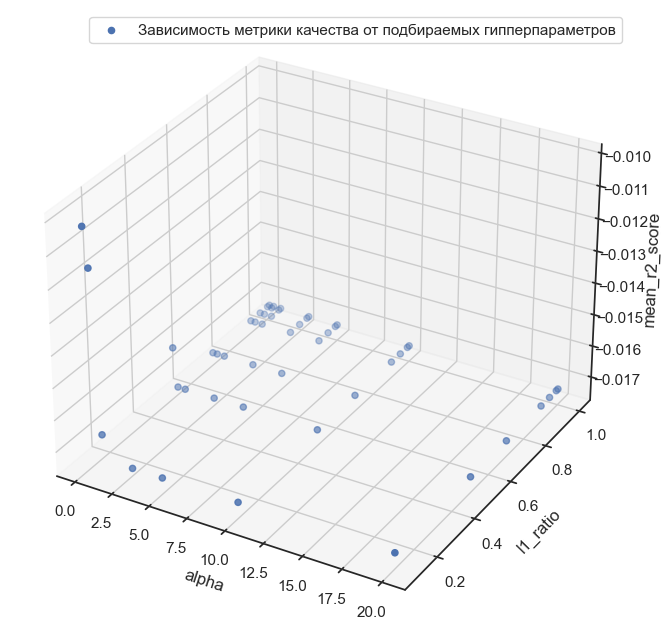

In [29]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(49):
    x, y = el_net_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, el_net_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
plt.xlabel('alpha')
plt.ylabel('l1_ratio')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [30]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
el_net_tuned.best_estimator_.fit(X_train_proc_str, y_train_proc_str)
el_net_predict_train_ = el_net_tuned.best_estimator_.predict(X_train_proc_str)
el_net_predict_test_ = el_net_tuned.best_estimator_.predict(X_test_proc_str)

In [31]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc_str, el_net_predict_train_), r2_score(y_test_proc_str, el_net_predict_test_)

(0.023985121169415646, -0.0038781515319177284)

In [32]:
el_net_predict_train_ = el_net_predict_train_.reshape(-1, 1)
el_net_predict_test_ = el_net_predict_test_.reshape(-1, 1)

In [33]:
# дестандартизация и денормализация предсказаных значений  
el_net_predict_train = pt_y_train.inverse_transform(el_net_predict_train_)
el_net_predict_test = pt_y_test.inverse_transform(el_net_predict_test_) 

In [34]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, el_net_predict_train), mean_squared_error(y_test, el_net_predict_test)

(223141.7292461722, 253514.27502370885)

In [35]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, el_net_predict_train), mean_absolute_error(y_test, el_net_predict_test)

(375.29675899445476, 393.06420645851694)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

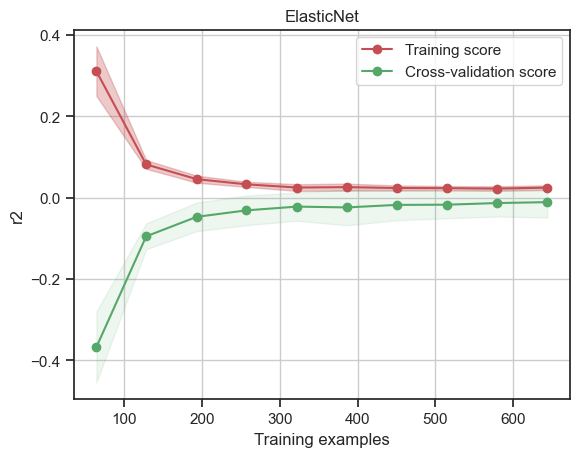

In [36]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                    X_train_proc_str, y_train_proc_str, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

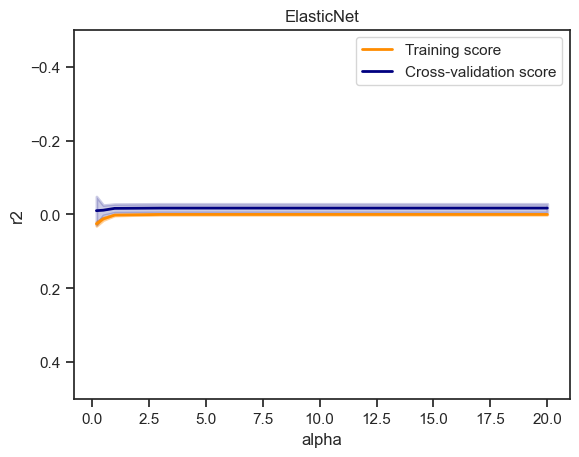

In [37]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='alpha', param_range=alpha_el_net, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

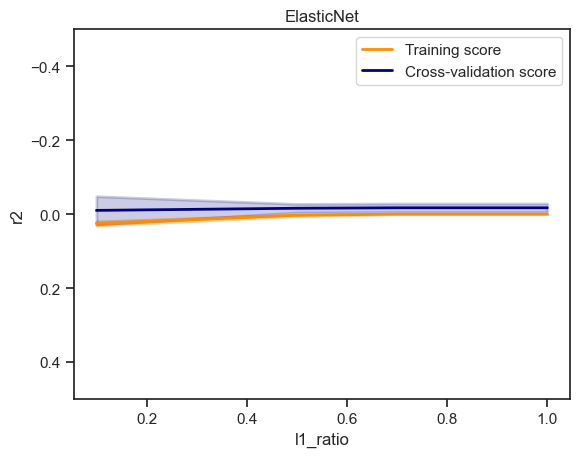

In [38]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(el_net_tuned.best_estimator_, 'ElasticNet', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='l1_ratio', param_range=l1_ratio_el_net, 
                      cv=10, scoring="r2")

#### 2.2 Регрессор Ridge

In [39]:
# Подбираем параметры alpha(по умолчанию = 1.0) - Constant that multiplies the L2 term, controlling regularization strength,
# alpha must be a non-negative float i.e. in [0, inf); и
# positive(default=False), when set to True, forces the coefficients to be positive. Only ‘lbfgs’ solver is supported in this case.
alpha_ridge = [1, 10, 100, 1000, 2136, 3000, 5000]
pos_ridge = [True, False]
ridge_tuned_parameters = [{'alpha' : alpha_ridge,
                          'positive' : pos_ridge}]

In [40]:
%%time
# обучаем модель
ridge_tuned = GridSearchCV(Ridge(random_state = 7), ridge_tuned_parameters, cv=10, scoring='r2')
ridge_tuned.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 1.08 s
Wall time: 2.52 s


GridSearchCV(cv=10, estimator=Ridge(random_state=7),
             param_grid=[{'alpha': [1, 10, 100, 1000, 2136, 3000, 5000],
                          'positive': [True, False]}],
             scoring='r2')

In [41]:
# выводим результат
ridge_tuned.best_params_

{'alpha': 1000, 'positive': False}

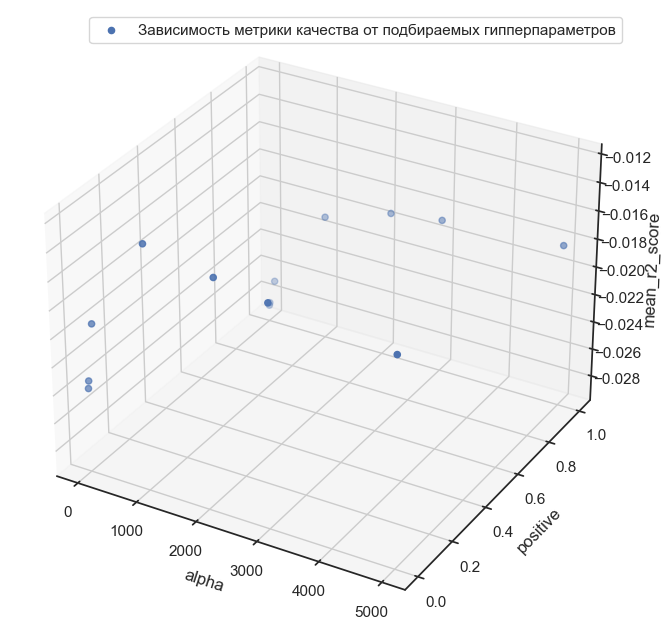

In [42]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []
for i in range(14):
    x, y = ridge_tuned.cv_results_['params'][i].values()
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, ridge_tuned.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')
plt.xlabel('alpha')
plt.ylabel('positive')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [43]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
ridge_tuned.best_estimator_.fit(X_train_proc_str, y_train_proc_str)
ridge_predict_train_ = ridge_tuned.best_estimator_.predict(X_train_proc_str)
ridge_predict_test_ = ridge_tuned.best_estimator_.predict(X_test_proc_str)

In [44]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc_str, ridge_predict_train_), r2_score(y_test_proc_str, ridge_predict_test_)

(0.019170145279862494, -0.0015470550754466128)

In [45]:
ridge_predict_train_ = ridge_predict_train_.reshape(-1, 1)
ridge_predict_test_ = ridge_predict_test_.reshape(-1, 1)

In [46]:
# дестандартизация и денормализация предсказаных значений  
ridge_predict_train = pt_y_train.inverse_transform(ridge_predict_train_)
ridge_predict_test = pt_y_test.inverse_transform(ridge_predict_test_)

In [47]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, ridge_predict_train), mean_squared_error(y_test, ridge_predict_test)

(224193.9264532496, 252924.7346910353)

In [48]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, ridge_predict_train), mean_absolute_error(y_test, ridge_predict_test)

(376.08523197493304, 392.92413448914516)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

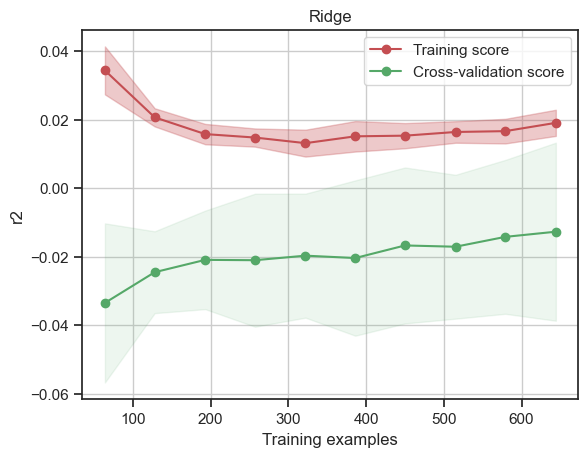

In [49]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(ridge_tuned.best_estimator_, 'Ridge', 
                    X_train_proc_str, y_train_proc_str, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

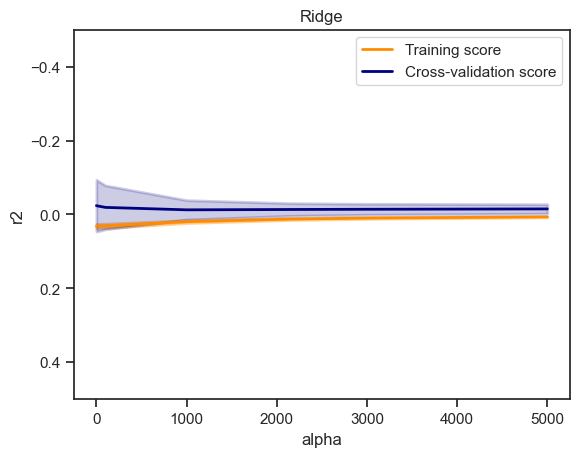

In [50]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(ridge_tuned.best_estimator_, 'Ridge', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='alpha', param_range = alpha_ridge, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

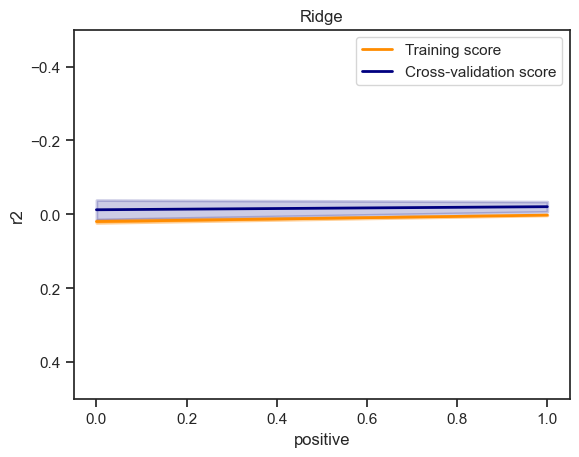

In [51]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(ridge_tuned.best_estimator_, 'Ridge', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='positive', param_range = pos_ridge, 
                      cv=10, scoring="r2")

#### 2.5 Машина опорных векторов (SVR) 

In [52]:
# подбираем параметры: 'kernel' - перебираем варианты ядра для модели (default=’rbf’),
# 'C' - регуляризация, сила регуляризации обратно пропрциональна 'C'(default=1.0), и
# 'gamma' - коэфф ядра для вариантов 'poly', 'rbf', 'sigmoid' (default=’scale’)
# ввиду ограниченности вычислительных мощностей сделаем это в два этапа
kernel_svr = ['linear', 'poly', 'rbf', 'sigmoid']
svr_tuned_parameters_1 = [{'kernel' : kernel_svr}]

In [54]:
%%time
# обучаем модель
y_train_proc_str = np.ravel(y_train_proc_str) 
svr_1 = GridSearchCV(SVR(), svr_tuned_parameters_1, cv=10, scoring='r2')
svr_1.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 2.28 s
Wall time: 2.3 s


GridSearchCV(cv=10, estimator=SVR(),
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='r2')

In [55]:
# выводим результат
svr_1.best_params_

{'kernel': 'linear'}

In [56]:
# как показал результат эксперимента выше, лучшим ядром модели для данной задачи (с остальными параметрами модели по умолчанию) является 'linear';
# подберем параметры 'C' и 'gamma' для этого ядра
C_svr = [0.2, 0.5, 1.0, 5, 10]
gamma_svr = ['scale', 'auto']
svr_tuned_parameters_2 = [{'C' : C_svr,
                         'gamma' : gamma_svr
                          }]

In [58]:
%%time
# обучаем модель
svr_2 = GridSearchCV(SVR(kernel = 'linear'), svr_tuned_parameters_2, cv=10, scoring='r2')
svr_2.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 13.6 s
Wall time: 13.6 s


GridSearchCV(cv=10, estimator=SVR(kernel='linear'),
             param_grid=[{'C': [0.2, 0.5, 1.0, 5, 10],
                          'gamma': ['scale', 'auto']}],
             scoring='r2')

In [59]:
# выводим результат
svr_2.best_params_

{'C': 0.2, 'gamma': 'scale'}

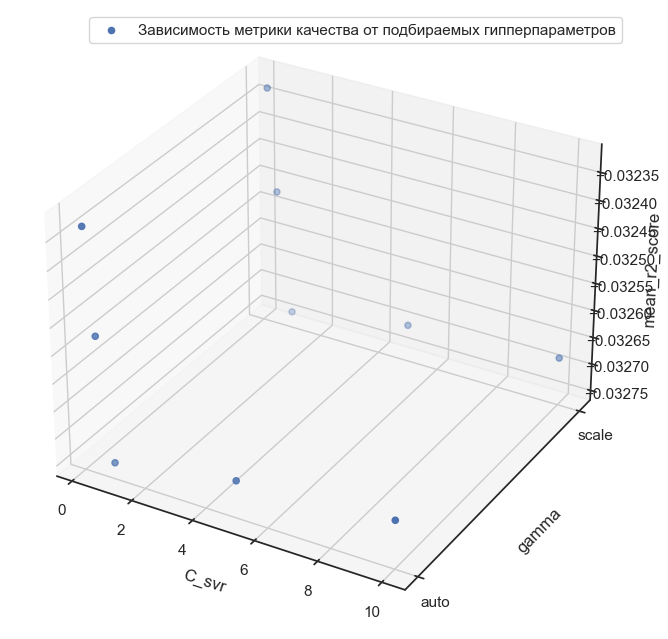

In [60]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(10):
    x, y = svr_2.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
yy_list = LabelEncoder().fit_transform(y_list)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, yy_list, svr_2.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

for i, j, k in zip(x_list, yy_list, svr_2.cv_results_['mean_test_score']):
    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('С_svr')
plt.ylabel('gamma')
ax.set_yticks([0, 1])
ax.set_yticklabels(['auto', 'scale'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [61]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
svr_2.best_estimator_.fit(X_train_proc_str, y_train_proc_str)
svr_2_predict_train_ = svr_2.best_estimator_.predict(X_train_proc_str)
svr_2_predict_test_ = svr_2.best_estimator_.predict(X_test_proc_str)

In [63]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc_str, svr_2_predict_train_), r2_score(y_test_proc_str, svr_2_predict_test_)

(0.022555807550622253, -0.05120085180953038)

In [64]:
svr_2_predict_train_ = svr_2_predict_train_.reshape(-1, 1)
svr_2_predict_test_ = svr_2_predict_test_.reshape(-1, 1)

In [65]:
# дестандартизация и денормализация предсказаных значений  
svr_2_predict_train = pt_y_train.inverse_transform(svr_2_predict_train_)
svr_2_predict_test = pt_y_test.inverse_transform(svr_2_predict_test_)

In [66]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, svr_2_predict_train), mean_squared_error(y_test, svr_2_predict_test)

(223371.56820796191, 265500.78807414667)

In [67]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, svr_2_predict_train), mean_absolute_error(y_test, svr_2_predict_test)

(373.2817028746867, 403.12811820134976)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

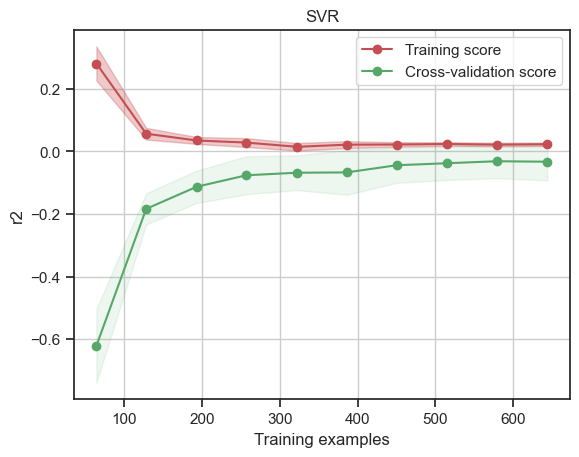

In [68]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(svr_2.best_estimator_, 'SVR', 
                    X_train_proc_str, y_train_proc_str, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

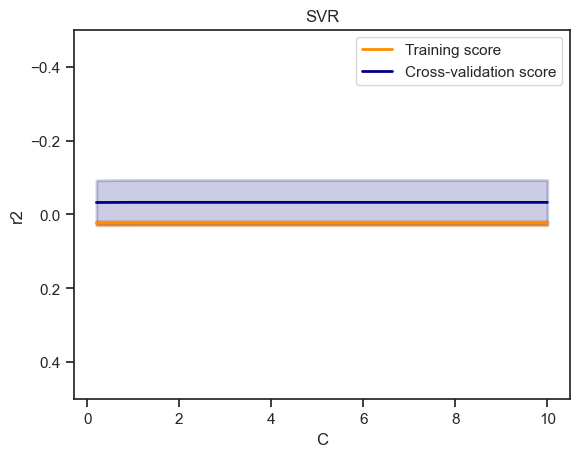

In [69]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(svr_2.best_estimator_, 'SVR', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='C', param_range = C_svr, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

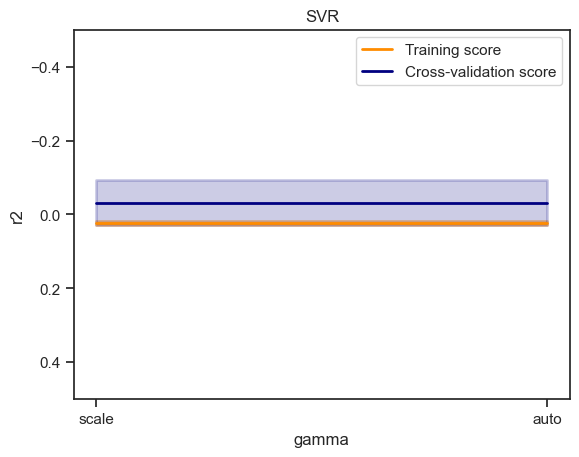

In [70]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(svr_2.best_estimator_, 'SVR', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='gamma', param_range = gamma_svr, 
                      cv=10, scoring="r2")

#### 2.8 Градиентный бустинг

In [79]:
# подбираем параметры: 'n_estimators' - the number of boosting stages to perform(default=100), и
# 'Learning rate' - shrinks the contribution of each tree by learning_rate(default=0.1).
GB_n_estimators = [100, 200, 300]
learning_rate = [0.01, 0.05, 0.1, 0.5, 1]
GB_tuned_parameters = [{'n_estimators' : GB_n_estimators,
                         'learning_rate' : learning_rate
                        }]

In [80]:
%%time
# обучаем модель
GB = GridSearchCV(GradientBoostingRegressor(random_state = 7), GB_tuned_parameters, cv=10, scoring='r2')
GB.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 2min 33s
Wall time: 2min 34s


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=7),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                          'n_estimators': [100, 200, 300]}],
             scoring='r2')

In [106]:
# выводим результат
GB.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

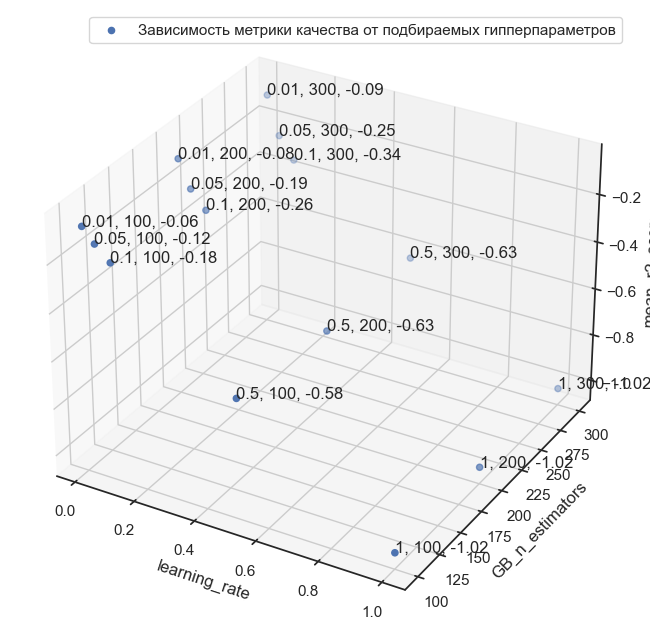

In [107]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(15):
    x, y = GB.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)

ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, GB.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

for i, j, k in zip(x_list, y_list, GB.cv_results_['mean_test_score']):
    text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('learning_rate')
plt.ylabel('GB_n_estimators')
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [81]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
GB.best_estimator_.fit(X_train_proc_str, y_train_proc_str)
GB_predict_train_ = GB.best_estimator_.predict(X_train_proc_str)
GB_predict_test_ = GB.best_estimator_.predict(X_test_proc_str)

In [82]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc_str, GB_predict_train_), r2_score(y_test_proc_str, GB_predict_test_)

(0.11576212462594027, -0.007609846471667403)

In [83]:
GB_predict_train_ = GB_predict_train_.reshape(-1, 1)
GB_predict_test_ = GB_predict_test_.reshape(-1, 1)

In [84]:
# дестандартизация и денормализация предсказаных значений  
GB_predict_train = pt_y_train.inverse_transform(GB_predict_train_)
GB_predict_test = pt_y_test.inverse_transform(GB_predict_test_)

In [85]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, GB_predict_train), mean_squared_error(y_test, GB_predict_test)

(202128.28191633552, 254422.63131725905)

In [86]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, GB_predict_train), mean_absolute_error(y_test, GB_predict_test)

(357.9069715147233, 394.5190436081066)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

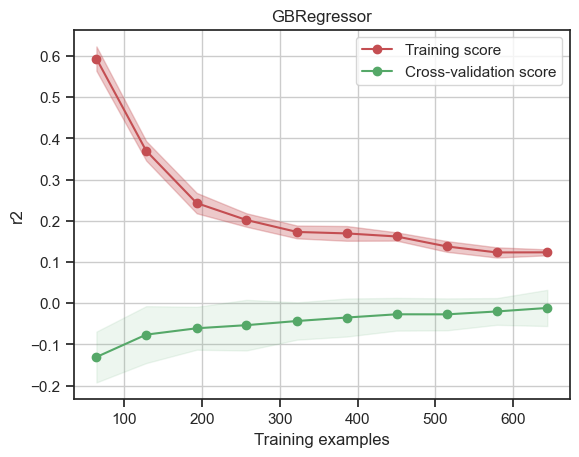

In [87]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(GB.best_estimator_, 'GBRegressor', 
                    X_train_proc_str, y_train_proc_str, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

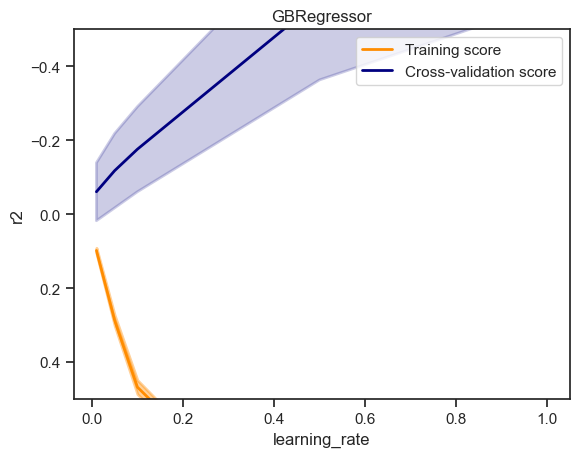

In [115]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(GB.best_estimator_, 'GBRegressor', 
                      X_train_proc, y_train_proc_, 
                      param_name='learning_rate', param_range = learning_rate, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

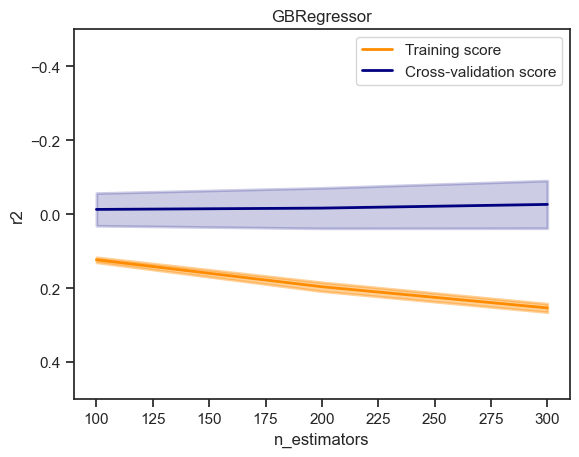

In [88]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(GB.best_estimator_, 'GBRegressor', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='n_estimators', param_range = GB_n_estimators, 
                      cv=10, scoring="r2")

#### 2.9 Случайный лес

In [89]:
# подбираем параметры: 'n_estimators' - the number of boosting stages to perform(default=100), и
# 'min_samples_split' - minimum number of samples required to split an internal node(default=2).
RF_n_estimators = [100, 200, 300]
RF_min_samples_split = [2, 10, 50, 100, 300]
RF_tuned_parameters = [{'n_estimators' : RF_n_estimators,
                         'min_samples_split' : RF_min_samples_split
                        }]

In [90]:
%%time
# обучаем модель
RF = GridSearchCV(RandomForestRegressor(random_state = 7), RF_tuned_parameters, cv=10, scoring='r2')
RF.fit(X_train_proc_str, y_train_proc_str)

CPU times: total: 4min 16s
Wall time: 4min 16s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'min_samples_split': [2, 10, 50, 100, 300],
                          'n_estimators': [100, 200, 300]}],
             scoring='r2')

In [91]:
# выводим результат
RF.best_params_

{'min_samples_split': 300, 'n_estimators': 200}

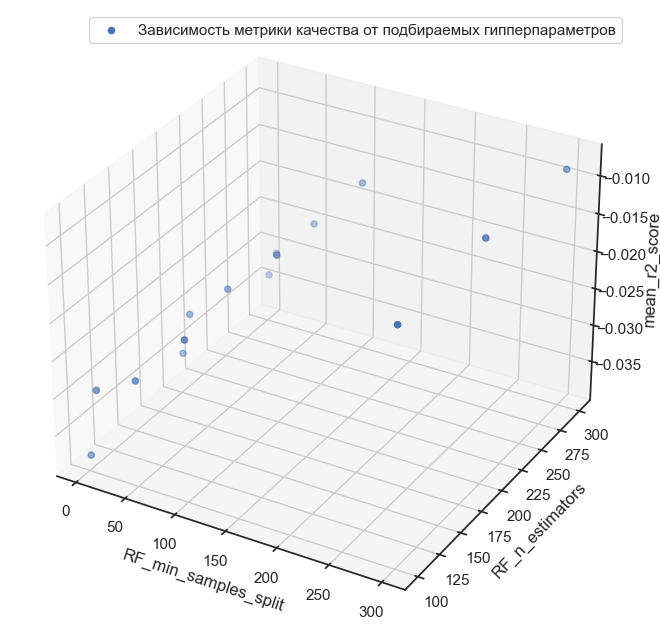

In [92]:
# прокладываем график зависимости метрики качества от подбираемых гипперпараметров
x_list = []
y_list = []

for i in range(15):
    x, y = RF.cv_results_['params'][i].values()
    
    x_list.append(x)
    y_list.append(y)
    
ax = plt.figure(figsize=(8,10)).add_subplot(projection='3d')
ax.scatter(x_list, y_list, RF.cv_results_['mean_test_score'], label='Зависимость метрики качества от подбираемых гипперпараметров')

# for i, j, k in zip(x_list, y_list, RF.cv_results_['mean_test_score']):
    # text = str(i) + ', ' + str(j) + ', ' + str(round(k, 2))
    # ax.text(i, j+0.01, k+0.005, text)

plt.xlabel('RF_min_samples_split')
plt.ylabel('RF_n_estimators')
# ax.set_xticks([0, 1, 2, 3])
# ax.set_xticklabels(['absolute_error', 'friedman_mse', 'poisson', 'squared_error'])
ax.set_zlabel('mean_r2_score')
ax.legend()
plt.show()

In [93]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
RF.best_estimator_.fit(X_train_proc_str, y_train_proc_str)
RF_predict_train_ = RF.best_estimator_.predict(X_train_proc_str)
RF_predict_test_ = RF.best_estimator_.predict(X_test_proc_str)

In [94]:
# Качество модели по метрике r2_score после подбора гиперпараметров
r2_score(y_train_proc_str, RF_predict_train_), r2_score(y_test_proc_str, RF_predict_test_)

(0.06556975081935679, 0.0012790619978367834)

In [95]:
RF_predict_train_ = RF_predict_train_.reshape(-1, 1)
RF_predict_test_ = RF_predict_test_.reshape(-1, 1)

In [96]:
# дестандартизация и денормализация предсказаных значений  
RF_predict_train = pt_y_train.inverse_transform(RF_predict_train_)
RF_predict_test = pt_y_test.inverse_transform(RF_predict_test_)

In [97]:
# Качество модели по метрике mean_squared_error после подбора гиперпараметров
mean_squared_error(y_train, RF_predict_train), mean_squared_error(y_test, RF_predict_test)

(213666.34388070434, 252188.30950922356)

In [98]:
# Качество модели по метрике mean_absolute_error после подбора гиперпараметров
mean_absolute_error(y_train, RF_predict_train), mean_absolute_error(y_test, RF_predict_test)

(367.35638797294564, 393.25786677216036)

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

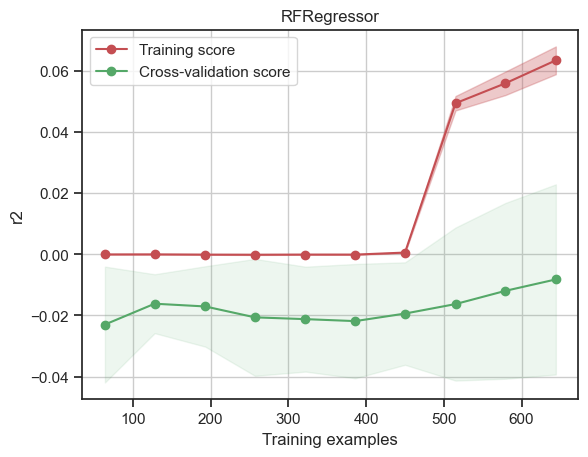

In [99]:
# Построение кривой обучения (зависимость качества модели от размера обучающей выборки)
plot_learning_curve(RF.best_estimator_, 'RFRegressor', 
                    X_train_proc_str, y_train_proc_str, cv=10, train_sizes=np.linspace(.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

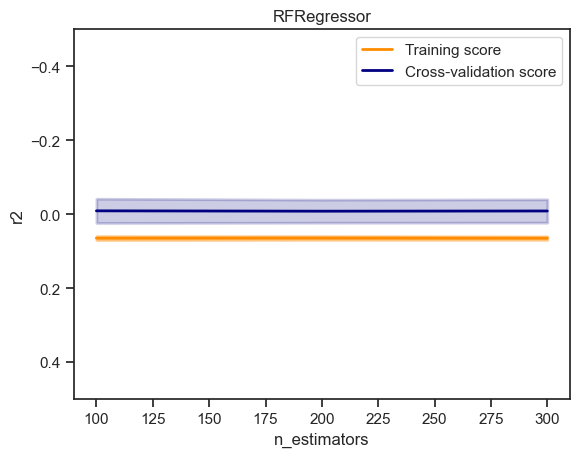

In [100]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(RF.best_estimator_, 'RFRegressor', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='n_estimators', param_range = RF_n_estimators, 
                      cv=10, scoring="r2")

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\VKR\\lib\\site-packages\\matplotlib\\pyplot.py'>

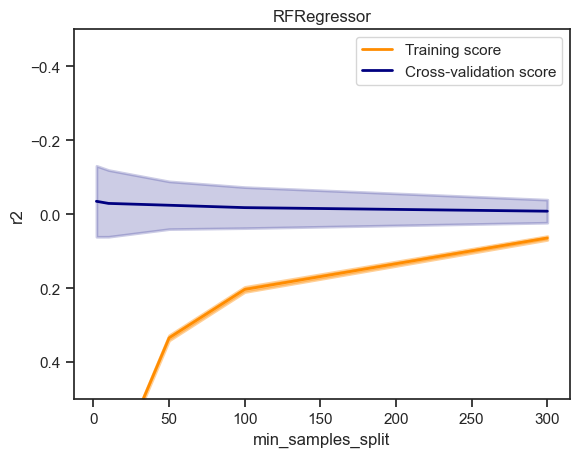

In [101]:
# Построение кривой валидации(зависимость качества модели от одного из гиперпараметров)
plot_validation_curve(RF.best_estimator_, 'RFRegressor', 
                      X_train_proc_str, y_train_proc_str, 
                      param_name='min_samples_split', param_range = RF_min_samples_split, 
                      cv=10, scoring="r2")

## 3. Сравнение полученных результатов

Соберем полученные метрики качества всех моделей в сводную таблицу для наглядности сравнения (будем оценивать по коэффициенту детерминации и МАЕ). 

In [102]:
# создаем словарь со значениями метрик
table = {'Models' : ['ElasticNet', 'Ridge', 'SVR', 'GradBoosting','RanForest'],

'R_2_train' : [ 
               r2_score(y_train_proc_str, el_net_predict_train_),
               r2_score(y_train_proc_str, ridge_predict_train_), r2_score(y_train_proc_str, svr_2_predict_train_),
               r2_score(y_train_proc_str, GB_predict_train_), r2_score(y_train_proc_str, RF_predict_train_)
              ],

'R_2_test' : [ 
              r2_score(y_test_proc_str, el_net_predict_test_),
              r2_score(y_test_proc_str, ridge_predict_test_), r2_score(y_test_proc_str, svr_2_predict_test_),
              r2_score(y_test_proc_str, GB_predict_test_), r2_score(y_test_proc_str, RF_predict_test_)
             ]
        }

In [105]:
# получаем датафрейм из словаря
table_df = pd.DataFrame(data = table)
# cортируем 
comp_table = table_df.sort_values(by=['R_2_test'], ascending=False)
index_tab = range(1, 6)
comp_table = comp_table.set_axis(index_tab, axis='index')
comp_table

,Models,R_2_train,R_2_test
1,RanForest,0.065570,0.001279
2,Ridge,0.019170,-0.001547
3,ElasticNet,0.023985,-0.003878
4,GradBoosting,0.115762,-0.007610
5,SVR,0.022556,-0.051201


In [106]:
# создаем словарь со значениями метрик
table_ = {'Models' : ['ElasticNet', 'Ridge', 'SVR', 'GradBoosting','RanForest'],

'MAE_train' : [
               mean_absolute_error(y_train, el_net_predict_train), mean_absolute_error(y_train, ridge_predict_train),
                 mean_absolute_error(y_train, svr_2_predict_train), 
               mean_absolute_error(y_train, GB_predict_train),
               mean_absolute_error(y_train, RF_predict_train)
              ],

'MAE_test' : [mean_absolute_error(y_test, el_net_predict_test),
                mean_absolute_error(y_test, ridge_predict_test), mean_absolute_error(y_test, svr_2_predict_test),
              mean_absolute_error(y_test, GB_predict_test), mean_absolute_error(y_test, RF_predict_test)
             ]
        }

In [107]:
# получаем датафрейм из словаря
table_df_ = pd.DataFrame(data = table_)
# cортируем 
comp_table_MAE = table_df_.sort_values(by=['MAE_test'], ascending=True)
index_tab_ = range(1, 6)
comp_table_MAE = comp_table_MAE.set_axis(index_tab_, axis='index')
comp_table_MAE

,Models,MAE_train,MAE_test
1,Ridge,376.085232,392.924134
2,ElasticNet,375.296759,393.064206
3,RanForest,367.356388,393.257867
4,GradBoosting,357.906972,394.519044
5,SVR,373.281703,403.128118


#### ВЫВОД: Как видно из таблиц выше, модели 'RandomForestRegressor' и 'RidgeRegressor' показывают лучшие результаты.